### How can the coupling error be estimated ?

In the first tutorials, we have only performed coupled simulations with a fixed coupling time step. It is however well known that time adaptation may lead to large computational gains, by allowing for much larger steps to be taken when possible, and also automatically lowering the time step in places where rapid changes occurs, or where the solution could become unstable.

To do so, traditional ODE integrators (e.g. those available in `scipy.integrate.solve_ivp`) use error estimates that, as the name suggests, estimate the error introduced by the numerical integration technique over a single time step. This is traditionally done by comparing two solutions with different orders of accuracy. Then, knowing the order of this estimate with respect to $\Delta t$, it is possible to dynamically choose the time step such that the estimate falls below a certain threshold.

In our framework, we may see various ways of estimating the coupling error.
For explicit coupled simulations, a very pragmatic one is to check how close the predicted coupling variables $\hat{u}_{i,n+1}$ are to the updated ones $u_{i,n+1}$. We may be happy if the discrepancy is sufficiently low:
$$||\hat{u}_{i,n+1} - u_{i,n+1}|| < tol$$

It can be shown that discrepancy is of the form $O(\Delta t^{p+1})$, with $p$ the degree of the predicition polynomials.

For implicit coupled simulations, this does not make sense, since both values are (almost) identical at convergence. One could think of using the initial explicit prediction to estimate the error. However, we have previously seen that the implicit coupling is much more accurate for a given stepsize than the explicit one, thus this would largely overestimate the error. In our experience, this approach is highly inefficient for implicit simulations.

An alternative is the *embedded approach*. We perform each step twice, with predictions of degree $p$ and $p+1$. Then, we compare the final coupling variables produced by both solutions. Since they both are implicit, the error is not polluted by coupling instabilities. In this case, the error estimate behaves like $O(\Delta t^{p+2})$.

Once an estimate $\epsilon$ is computed for a coupling time step $\Delta t_1$, we can compute the "optimal" time step that would produce an error exactly equal to the tolerance:
$$ \epsilon = A\Delta t_1^{p+1} > tol$$
$$ tol = A\Delta t_{opt}^{p+1}$$
$$\Rightarrow ~ \Delta t_{opt} = \Delta t_1 \left(\dfrac{tol}{\epsilon}\right)^{p+1}$$

In practice a safety factor is applied to ensure that the error in lower than the threshold.

Let us try this approach with our previous toy model.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from rhapsopy.coupling import Orchestrator, BaseCoupler
from rhapsopy.accelerators import NewtonSolver, DampedNewtonSolver, IQNSolver, AitkenUnderrelaxationSolver, AitkenScalarSolver, FixedPointSolver, AndersonSolver, ExplicitSolver

def odefun_single(t,x,inputs):
    # x = [position, speed]
    dxdt = np.zeros((2,))
    dxdt[0] = x[1]
    dxdt[1] = (1/m) * ( k*(inputs['xip1'](t)-x[0]-L0) - k*(x[0]-inputs['xim1'](t)-L0) )
    return dxdt

class SpringMassCoupler(BaseCoupler):
    def __init__(self,k,m):
        self.k = k
        self.m = m
        self.nCouplingVars = 2 # we have 2 coupling variables: the positions of both masses
        self.nSubsystems   = 2 # we have 2 coupled subsystems
        
    def getCouplingVars(self,t,y):
        """ Return the coupling variables, which are simply the speed and positions of the nodes """
        return y[::2]

    def integrateSingleSubsystem(self, isolv, t0, y0, dt, preds, rtol=None, bDebug=False):
        """ Performs one iteration of a code coupling step (Jacobi or Gauss-Seidel)
              --> computes the value of the overall state vector at time t+dt,
                  starting from state y at time t. """
        # get each subsystem's state vector
        y0_subsystems = [y0[2*i:2*(i+1)] for i in range(2)]
        
        # Distribute the predictions
        current_input = {}
        if isolv==0: # first mass
            current_input['xim1'] = lambda t: 0. # left attachment point
            current_input['xip1'] = lambda t: preds[1].evaluate(t)
        else: # second mass
            current_input['xim1'] = lambda t: preds[0].evaluate(t)
            current_input['xip1'] = lambda t: 1. # right attachment point

        # perform time integration
        if rtol is None: rtol=1e-6
        atol = rtol
        current_out = solve_ivp(fun=lambda t,y : odefun_single(t, y, inputs=current_input),
                                y0=y0_subsystems[isolv], t_span=[t0,t0+dt],
                                max_step=dt, first_step=dt/2, #TODO: sometimes first_step=dt raises issues in Scipy
                                method='RK45', atol=atol, rtol=rtol)
        if not current_out.success:
            raise Exception(current_out.message)
        return current_out
    

In [4]:
k=1000.
m=1.
L0=1.
y0_global = np.array([0.3, 0, 0.8, 0])
tf = 0.5
coupler = SpringMassCoupler(k=k,m=m)

A=np.array(((0.,1,0,0),
            (-2*k/m,0,k/m,0),
            (0,0,0,1),
            (k/m,0,-2*k/m,0)))
def coupled_ode(t,y):
    return A @ y + np.array((0.,0,0,k/m))

# monolithic approach
sol = solve_ivp(fun=coupled_ode, dense_output=True,
                y0=y0_global, t_span=[0.,10.],
                method='DOP853', atol=1e-12, rtol=1e-12)

We can now test the adaptive coupled integration, in explicit or implicit mode, with or without embedded error estimate:

In [5]:
rtol = 1e-4

conductor_implicit = Orchestrator(coupler=coupler, order=3)
conductor_implicit.interfaceSolver = FixedPointSolver
conductor_implicit.waveform_tolerance = min(1e-4, rtol/10.)
conductor_implicit.NITER_MAX = 20
conductor_implicit.raise_error_on_non_convergence = True

conductor_explicit = Orchestrator(coupler=coupler, order=3)
conductor_explicit.interfaceSolver = ExplicitSolver
conductor_explicit.embedded_method = False
conductor_explicit.NITER_MAX = 1
conductor_explicit.raise_error_on_non_convergence = True

conductor_implicit.embedded_method = False
solcoupled_implicit = conductor_implicit.adaptive_integration(y0=y0_global, t_span=np.array([0,tf]),
                                                        first_step=1e-1,
                                                        atol=rtol/10, rtol=rtol, adaptive_order=False)
conductor_explicit.embedded_method = False
solcoupled_explicit = conductor_explicit.adaptive_integration(y0=y0_global, t_span=np.array([0,tf]),
                                                        first_step=1e-1,
                                                        atol=rtol/10, rtol=rtol, adaptive_order=False)

conductor_implicit.embedded_method = True
solcoupled_implicit_embedded = conductor_implicit.adaptive_integration(y0=y0_global, t_span=np.array([0,tf]),
                                                                 first_step=1e-1,
                                                                 atol=rtol/10, rtol=rtol, adaptive_order=False)
conductor_explicit.embedded_method = True
solcoupled_explicit_embedded = conductor_explicit.adaptive_integration(y0=y0_global, t_span=np.array([0,tf]),
                                                                 first_step=1e-1,
                                                                 atol=rtol/10, rtol=rtol, adaptive_order=False)


Let us plot the solution dynamics.

Text(0.5, 1.0, 'Solution dynamics')

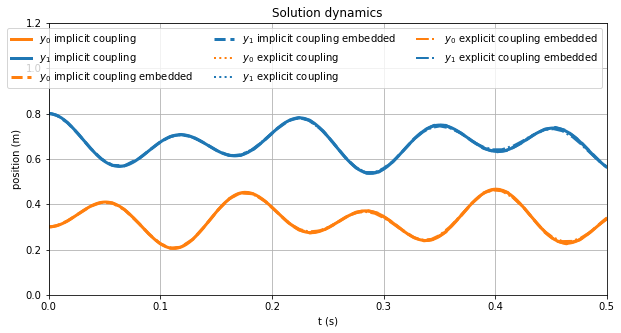

In [6]:
plt.figure(figsize=(10,5))

plt.plot(solcoupled_implicit.t, solcoupled_implicit.y[0,:],
         color='tab:orange', linestyle='-', linewidth=3, label=r'$y_0$ implicit coupling')
plt.plot(solcoupled_implicit.t, solcoupled_implicit.y[2,:],
         color='tab:blue', linestyle='-', linewidth=3, label=r'$y_1$ implicit coupling')

plt.plot(solcoupled_implicit_embedded.t, solcoupled_implicit_embedded.y[0,:],
         color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ implicit coupling embedded')
plt.plot(solcoupled_implicit_embedded.t, solcoupled_implicit_embedded.y[2,:],
         color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ implicit coupling embedded')

plt.plot(solcoupled_explicit.t, solcoupled_explicit.y[0,:],
         color='tab:orange', linestyle=':', linewidth=2, label=r'$y_0$ explicit coupling')
plt.plot(solcoupled_explicit.t, solcoupled_explicit.y[2,:],
         color='tab:blue', linestyle=':', linewidth=2, label=r'$y_1$ explicit coupling')

plt.plot(solcoupled_explicit_embedded.t, solcoupled_explicit_embedded.y[0,:],
         color='tab:orange', linestyle='-.', linewidth=2, label=r'$y_0$ explicit coupling embedded')
plt.plot(solcoupled_explicit_embedded.t, solcoupled_explicit_embedded.y[2,:],
         color='tab:blue', linestyle='-.', linewidth=2, label=r'$y_1$ explicit coupling embedded')

plt.ylim(0,1.2)
plt.legend(ncol=3)
plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.title(f'Solution dynamics')

The various solutions are undistinguishable. Let us study the absolute error with respect to the monolithic solution.

Text(0.5, 1.0, 'Gap to monolithic quasi-exact solution')

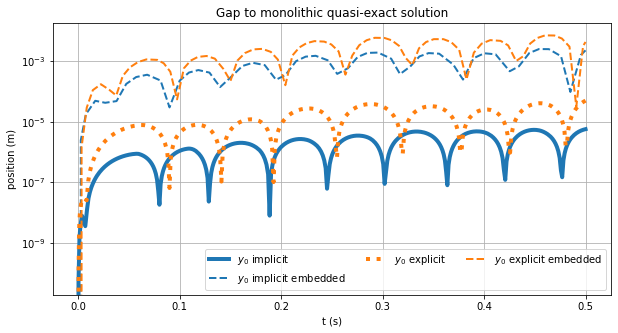

In [7]:
plt.figure(figsize=(10,5))

plt.semilogy(solcoupled_implicit.t, abs(solcoupled_implicit.y[0,:]-sol.sol(solcoupled_implicit.t)[0,:]),
         color='tab:blue', linestyle='-', linewidth=4, label=r'$y_0$ implicit')

plt.plot(solcoupled_implicit_embedded.t, abs(solcoupled_implicit_embedded.y[0,:]-sol.sol(solcoupled_implicit_embedded.t)[0,:]),
         color='tab:blue', linestyle='--', linewidth=2, label=r'$y_0$ implicit embedded')
#plt.plot(solcoupled_implicit_embedded.t, abs(solcoupled_implicit_embedded.y[2,:]-sol.sol(solcoupled_implicit_embedded.t)[2,:]),
#         color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ implicit embedded')

plt.plot(solcoupled_explicit.t, abs(solcoupled_explicit.y[0,:]-sol.sol(solcoupled_explicit.t)[0,:]),
         color='tab:orange', linestyle=':', linewidth=4, label=r'$y_0$ explicit')
#plt.plot(solcoupled_explicit.t, abs(solcoupled_explicit.y[2,:]-sol.sol(solcoupled_explicit.t)[2,:]),
#         color='tab:blue', linestyle=':', linewidth=2, label=r'$y_1$ explicit')

plt.plot(solcoupled_explicit_embedded.t, abs(solcoupled_explicit_embedded.y[0,:]-sol.sol(solcoupled_explicit_embedded.t)[0,:]),
         color='tab:orange', linestyle='--', linewidth=2, label=r'$y_0$ explicit embedded')
#plt.plot(solcoupled_explicit_embedded.t, abs(solcoupled_explicit_embedded.y[2,:]-sol.sol(solcoupled_explicit_embedded.t)[2,:]),
#         color='tab:blue', linestyle='-.', linewidth=2, label=r'$y_1$ explicit embedded')


plt.legend(ncol=3)
plt.grid()
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.title(f'Gap to monolithic quasi-exact solution')



We see that the coupled simulations with the embedded error estimate produce larger errors. But actually, the non-embedded approaches produce an error much lower than the prescribed error tolerance.

Let us take a look at the time steps used by the different approaches:

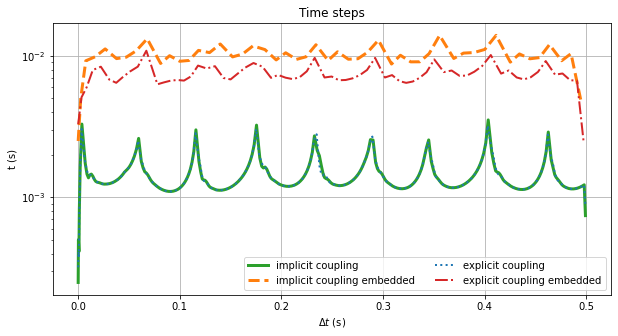

In [9]:
plt.figure(figsize=(10,5))

plt.semilogy(solcoupled_implicit.t[:-1], np.diff(solcoupled_implicit.t),
         color='tab:green', linestyle='-', linewidth=3, label=r'implicit coupling')

plt.plot(solcoupled_implicit_embedded.t[:-1], np.diff(solcoupled_implicit_embedded.t),
         color='tab:orange', linestyle='--', linewidth=3, label=r'implicit coupling embedded')

plt.plot(solcoupled_explicit.t[:-1], np.diff(solcoupled_explicit.t),
         color='tab:blue', linestyle=':', linewidth=2, label=r'explicit coupling')

plt.plot(solcoupled_explicit_embedded.t[:-1], np.diff(solcoupled_explicit_embedded.t),
         color='tab:red', linestyle='-.', linewidth=2, label=r'explicit coupling embedded')

plt.legend(ncol=2)
plt.grid()
plt.xlabel(r'$\Delta t$ (s)')
plt.ylabel('t (s)')
plt.title(f'Time steps');


We see that the embedded error estimate allows for much larger time steps to be taken.
On the opposite, the explicit error estimate (error of the initial extrapolation) greatly overestimates the error, resulting in a smaller average time step and a larger computational cost overall.

It is also worth noting that, without embedded error estimate, the implicitly coupled simulation takes exactly the same time steps as the explicit one, even though we have previously seen that the implicit simulation naturally produces a smaller error. This clearly demonstrate the inadequacy of the explicit error estimate for implicit simulations.

Finally, we can take a look at the number of fixed-point iterations required by each approach:

Text(0.5, 1.0, 'WR iterations steps')

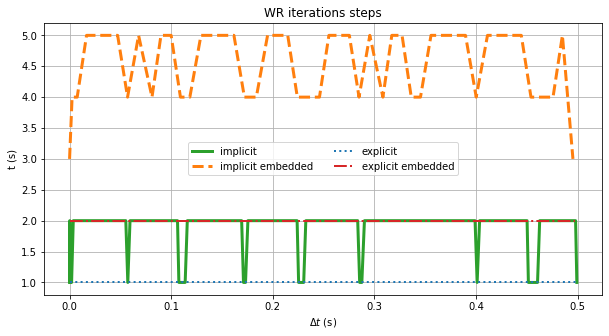

In [11]:
plt.figure(figsize=(10,5))

plt.plot(solcoupled_implicit.t[:-1], solcoupled_implicit.WR_iters,
         color='tab:green', linestyle='-', linewidth=3, label=r'implicit')

plt.plot(solcoupled_implicit_embedded.t[:-1], solcoupled_implicit_embedded.WR_iters+solcoupled_implicit_embedded.WR_iters2,
         color='tab:orange', linestyle='--', linewidth=3, label=r'implicit embedded')

plt.plot(solcoupled_explicit.t[:-1], solcoupled_explicit.WR_iters,
         color='tab:blue', linestyle=':', linewidth=2, label=r'explicit')

plt.plot(solcoupled_explicit_embedded.t[:-1], solcoupled_explicit_embedded.WR_iters+solcoupled_explicit_embedded.WR_iters2,
         color='tab:red', linestyle='-.', linewidth=2, label=r'explicit embedded')

plt.legend(ncol=2)
plt.grid()
plt.xlabel(r'$\Delta t$ (s)')
plt.ylabel('t (s)')
plt.title(f'WR iterations steps')


The explicit coupling with the extrapolated error estimate requires only one integration of each subsystem per coupling step. The embedded estimate requires another integration to be made.

In the case of implicit coupling with the extrapolated error estimate, the number of iterations is roughly 2 on average. This shows that the fixed-point solution converges very quickly, which is also due to the fact that the time step is unnecessarily small (remember the tutorial on implicit coupling, the Lipschitz constant of the function whose fixed-point we seek is proportional do $\Delta t$).

In the case of the embedded error estimate, another implicit solution has to be compute at each step, which roughly doubles the number of iterations. This additional cost is however largely overcome by the fact that we can use a much larger time step.